In [24]:
import os
import sys
import numpy as np
os.environ["THEANO_FLAGS"] = "device=cpu"
%matplotlib inline
sys.path.append(os.getcwd()+"/..")
from lightjob.cli import load_db
from collections import Counter
import glob
db = load_db()

In [2]:
def hash_matrix_to_int(hm):
    cnt = Counter(hm)
    s = np.argsort(cnt.values())[::-1]
    K = cnt.keys()
    K = [K[s[i]] for i in range(len(K))]
    K_to_int = {k: i + 1 for i, k in enumerate(K)}
    x = [K_to_int[v] for v in hm]
    x = np.array(x)
    return x


def unique_indices(hm):
    K = {}
    for i, h in enumerate(hm):
        if h not in K:
            K[h] = i
    return K.values()

def get_images(filenames):
    from skimage.io import imread
    for f in filenames:
        im = imread(f)
        im = 2 * (im / im.max()) - 1
        assert set(im.flatten().tolist()) <= set([1, -1]), set(im.flatten().tolist())
        yield im

In [14]:
s = 'd6ada23433955628d3a893310d3287f5'
job = db.get_job_by_summary(s)
print(job['content'])
job_folder = "../jobs/results/{}".format(s)
hash_matrix_filename = os.path.join(job_folder, "csv", "hashmatrix.npy")
hash_matrix = np.load(hash_matrix_filename)
x = hash_matrix_to_int(hash_matrix)

{u'model_summary': u'a5eedb043b15ceb54c0073580f47d05d', u'check': {u'what': u'simple_genetic', u'filename': u'jobs/results/a5eedb043b15ceb54c0073580f47d05d/model.pkl', u'params': {u'sort': True, u'op_names': [], u'op_params': [], u'initial': u'random', u'initial_size': 10000, u'up_binarize': 0.5, u'nb_iterations': 100, u'layer_name': u'input', u'tol': 0, u'reconstruct': True, u'down_binarize': None}, u'dataset': u'digits'}}


In [5]:
filenames = glob.glob(os.path.join(job_folder, 'final', '*.png'))
filenames = sorted(filenames)
indices = unique_indices(hash_matrix)
filenames = [filenames[ind] for ind in indices]

In [6]:
X = []
for im in get_images(filenames):
    X.append([im])
X = np.concatenate(X, axis=0)
X = X.reshape((X.shape[0], -1))

In [32]:
from sklearn.neighbors import KernelDensity
from lasagnekit.datasets.mnist import MNIST
data = MNIST()
data.load()

In [34]:
k = KernelDensity()
k.fit(data.X[0:10000])

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [15]:
from tasks import check

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/mcherti/work/code/scikit-learn/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.19.
  "This module will be removed in 0.19.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [16]:
v = check(what="notebook", 
          filename="../jobs/results/a5eedb043b15ceb54c0073580f47d05d/model.pkl", 
          dataset="digits")

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...


{'seed': 2}


/home/mcherti/work/code/Lasagne/lasagne/layers/helper.py:212: UserWarning: get_output() was called with unused kwargs:
	determnistic (perhaps you meant deterministic)
  % "\n\t".join(suggestions))


In [17]:
capsule, data, layers, w, h, c = v

In [41]:
import numpy as np
np.random.seed(1234)
s = np.random.uniform(size=(10, c, w,h))
s = s.astype(np.float32)
loss = []
scores = []
for i in range(100):
    score = np.sum(k.score_samples(s.reshape((s.shape[0], -1))))
    scores.append(score)
    print(score)
    sprev = s
    s = capsule.reconstruct(s)
    s = s > 0.5
    s = s.astype(np.float32)
    score = np.abs(s - sprev).sum()
    loss.append(score)
    if score == 0:
        break
    loss.append(score)

-8040.45195817
-7618.06155502
-7591.74263772
-7561.42360657
-7558.63803406
-7557.52804502
-7551.94504721
-7544.54841732
-7552.49945918
-7546.74012575
-7551.43605774
-7539.56187243
-7547.75411703
-7548.02280789
-7541.78723805
-7542.64694627
-7541.41267117


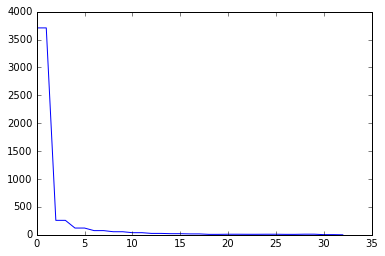

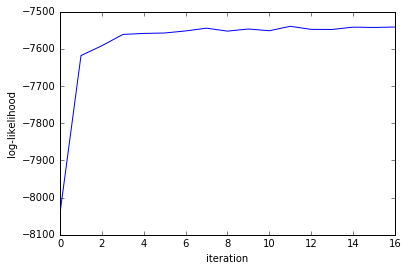

('Nb of iterations', 33)


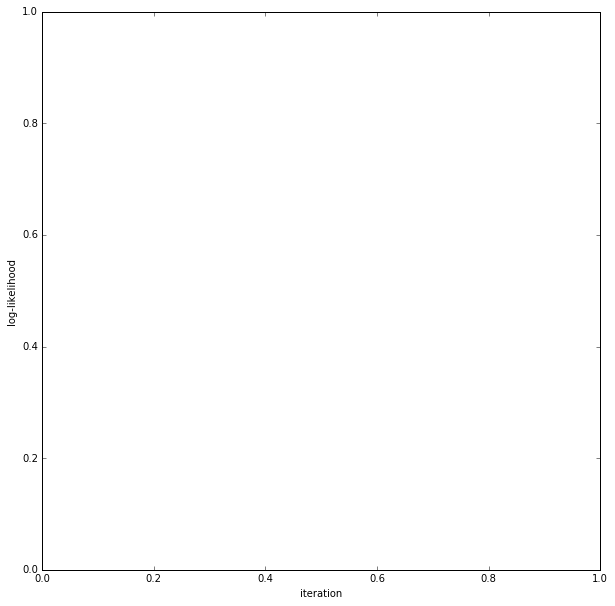

float32


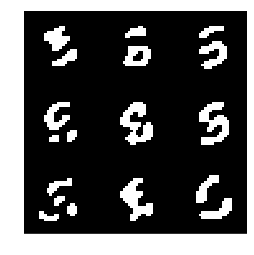

In [42]:
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
%matplotlib inline
import matplotlib.pyplot as plt
s = s.astype(np.float32)
plt.plot(loss)
plt.show()
plt.plot(scores)
plt.xlabel('iteration')
plt.ylabel('log-likelihood')
plt.show()
print("Nb of iterations", len(loss))
sz = int(np.sqrt(s.shape[0]))
fig = plt.figure(figsize=(10, 10))
plt.xlabel('iteration')
plt.ylabel('log-likelihood')
plt.show()


if s.shape[1] == 1:
    print(s.dtype)
    img = tile_raster_images(s[:, 0], (w, h), (sz, sz), tile_spacing=(2, 2), )
    plt.imshow(img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()
else:
    ss = s.transpose((0, 2, 3, 1))
    print(s.shape)
    img = dispims_color(ss)
    plt.imshow(img)
    plt.axis('off')
    plt.show()